# Data integration
* In 3.10.21 new data was added to cohort:
    - 25 samples M147-M173

* this script is built to integrate the samples to one complete cohort.

* Then, we can adjust all clustering files to the new cohort. 

In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic, transpose, bold
from general_helpers import create_folder
from scipy.stats import ranksums, wilcoxon
from shutil import copyfile
import matplotlib.pyplot as plt
import random
from utilities.clustering_tools import find_marker_genes_in_cluster, find_markers_in_clusters
from utilities.clustering_tools import multipletests_fdr
from utilities.general_helpers import intersection_of_lists
from scipy.spatial.distance import cdist
from utilities.droplet_dataset import get_requested_subset


### Combines cohorts:

Specify if normalized:

In [2]:
NORMALIZED = False

if NORMALIZED:
    str_normalized = 'normalized'
else:
    str_normalized = 'non_normalized'

Load cohorts:

In [3]:
EXISTING_COHORT_PATH = fr'/storage/md_keren/shitay/Data/droplet_seq/M97_M146/cohort/{str_normalized}/4.11.21/cohort_{str_normalized}_4.11.21.pkl'
OCT_COHORT_PATH = fr'/storage/md_keren/shitay/Data/droplet_seq/M147_M173/cohort/{str_normalized}/4.11.21/cohort_{str_normalized}_4.11.21.pkl'

existing_cohort =  pickle.load(open(EXISTING_COHORT_PATH, 'rb'))
oct_cohort = pickle.load(open(OCT_COHORT_PATH, 'rb'))
print(f'Number of cells in exisiting cohort: {existing_cohort.number_of_cells}')
print(f'Number of cells in OCT cohort: {oct_cohort.number_of_cells}')

Number of cells in exisiting cohort: 192778
Number of cells in OCT cohort: 143429


Integrate:

In [4]:
integrated_cohort = existing_cohort + oct_cohort
print(f'Number of cells in integrated cohort: {integrated_cohort.number_of_cells}')

Number of cells in integrated cohort: 336207


Save integrated cohort:

In [15]:
INTEGRATED_COHORT_PATH = fr'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/{str_normalized}/4.11.21/cohort_{str_normalized}_4.11.21.pkl'
pickle.dump((integrated_cohort), open(INTEGRATED_COHORT_PATH, 'wb'), protocol=4)
print(f'cohort was saved in {INTEGRATED_COHORT_PATH}')

cohort was saved in /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/4.11.21/cohort_non_normalized_4.11.21.pkl


# Adjust Immune\CD8\Myeloid clustering to the integrated cohort

Integration needed when new data arrives. The process involves clustering each cell in new data into existing clusters, such as immune clusters, CD8 clusters, and myeloid clusters. Here, we calculate the distances of cells with the centroids of existing clusters. Following that, each cell is assigned to the cluster whose centroid is closest. ####

## 1. Immune clustering
 - 1.1 (A) take only Immune cells from cohorts.
 - 1.1 (B) Loads Immune clustering mapping df.

##### Get cluster centroids (A: Calculate / B: Load):
 - 1.2. Calculating centroids (AVG) of immune clusters: (if already done you can skip it and load centroids from server)
 - 1.3 ( -> A  |B) save centroids of clusters.
 - 1.3 (A| -> B  ) Load centroids.


##### calculating distance from centroids and creating mapping df for integrated data:
 - 1.4. Creating DF of immune clusters for OCT data, the cluster of a cell is the cluster with the closet centroid
 - 1.5. take the mapping of existing_cohort (the new order)
 - 1.6 Combine cluster mappinbg of existing cohort with oct cohort:
 - 1.7 Save mapping_df of integrated cohort:

##### 1.1 (A) Extract only immune cells (for future analysis, used for mapping cells to immune clusters for OCT data):
### NOTE: YOU SHOULD RUN THIS BLOCK FOR IMMUNE|CD8|MYLOIDS (all of them) clustering mapping update!!!

In [6]:
immune_existing_cohort = existing_cohort.filter_cells_by_property('is_immune', True)
immune_oct_cohort = oct_cohort.filter_cells_by_property('is_immune', True)

##### 1.1 (B) Loads immune clustering mapping df 

In [70]:
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
immune_clustering_df = pd.read_csv(clusters_barcodes_mapping_path).drop(columns=['Unnamed: 0', 'index'])

##### 1.2 Calculating centroids (AVG) of immune clusters: (if already done you can skip it and load centroids from server)

In [78]:
cohort_ids = list(zip(immune_existing_cohort.barcodes, immune_existing_cohort.samples))
immune_centroids = {}

clusters = sorted(set(immune_clustering_df['Cluster']))
for cluster_idx in clusters:
    cluster_i_df = immune_clustering_df[immune_clustering_df['Cluster']==cluster_idx]
    print(f'cluster {cluster_idx}, num of cells in cluster: {len(cluster_i_df)}', end=' ')
    cluster_ids = list(zip(cluster_i_df['Barcode'].values.tolist(), cluster_i_df['Sample'].values.tolist()))
    overlap_ids = intersection_of_lists(cluster_ids, cohort_ids)
    print(f', num of non-empty cells in cluster: {len(overlap_ids)}', end='\n\n')
    cluster_i_cohort = immune_existing_cohort.get_subset_by_identifiers(np.array(overlap_ids)[:,1], np.array(overlap_ids)[:,0])

    # Calculate centroif of cluster
    centroid = np.average(cluster_i_cohort.counts, axis=0)
    immune_centroids[cluster_idx] = centroid

cluster 1, num of cells in cluster: 6505 , num of non-empty cells in cluster: 5842

cluster 2, num of cells in cluster: 4537 , num of non-empty cells in cluster: 4514

cluster 3, num of cells in cluster: 3385 , num of non-empty cells in cluster: 3186

cluster 4, num of cells in cluster: 2950 , num of non-empty cells in cluster: 2849

cluster 5, num of cells in cluster: 12924 , num of non-empty cells in cluster: 12379

cluster 6, num of cells in cluster: 10061 , num of non-empty cells in cluster: 9400

cluster 7, num of cells in cluster: 4726 , num of non-empty cells in cluster: 4614

cluster 8, num of cells in cluster: 10521 , num of non-empty cells in cluster: 9886

cluster 9, num of cells in cluster: 6522 , num of non-empty cells in cluster: 5997

cluster 10, num of cells in cluster: 3341 , num of non-empty cells in cluster: 3297

cluster 11, num of cells in cluster: 5345 , num of non-empty cells in cluster: 4005

cluster 12, num of cells in cluster: 8676 , num of non-empty cells in 

##### 1.3 ( -> A  |B) save centroids of clusters:

In [169]:
pickle.dump(immune_centroids, open(r'/storage/md_keren/shitay/garbage/centroids.pkl', 'wb'))

##### 1.3 (A| -> B  ) Load centroids:

In [6]:
immune_centroids = pickle.load(open(r'/storage/md_keren/shitay/garbage/centroids.pkl', 'rb'))

##### 1.4 Creating DF of immune clusters for OCT data, the cluster of a cell is the cluster with the closet centroid

In [9]:
# correlation distance of immune_oct_cohort from centroids, argmin+1 to keep the idx of the closet cluster:
counting_table = immune_oct_cohort.counts
oct_cohort_mapping_clusters = np.argmin(cdist(list(immune_centroids.values()), counting_table, 'correlation'), axis=0) + 1

# Cancel comment if you want to see distribution of number of cells (new data) in each cluster.
# Counter(oct_cohort_mapping_clusters)

In [56]:
oct_cohort_cluster_mapping_df = pd.DataFrame(list(zip(immune_oct_cohort.samples, immune_oct_cohort.barcodes, oct_cohort_mapping_clusters)), columns=['Sample', 'Barcode', 'Cluster'])
oct_cohort_cluster_mapping_df.head(5)

##### 1.5 take the mapping of existing_cohort (the new order)

immune_clustering_df contains for each immune cell (with identifier sample&barcode) the corresponding immune cluster. but there are some cells that dont appear there (few number that were excluded).

we will update a new df (existing_clustering_df) with the mapping information corresponding the existing cohort (M97-M146). it should be "kind of identical" to the immune_clustering_df, but the to make sure about the order or/and exclude the non_empty cells from the original DF we use it.

In [53]:
existing_clustering_df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster'])
immune_clustering_df = immune_clustering_df.set_index(['Sample', 'Barcode'])

for i in range(immune_existing_cohort.number_of_cells):
    sample = immune_existing_cohort.samples[i]
    barcode = immune_existing_cohort.barcodes[i]
    
    try:
        cluster = immune_clustering_df.loc[(sample, barcode)]['Cluster']
        existing_clustering_df = existing_clustering_df.append(pd.DataFrame([[sample, barcode, cluster]], columns=existing_clustering_df.columns))
    except KeyError:
        print(f"{(sample, barcode)} has no cluster.")
    
    
existing_clustering_df.head(5)

##### 1.6 Combine cluster mappinbg of existing cohort with oct cohort:

In [67]:
integrated_cohort_clustering_df = existing_clustering_df.append(oct_cohort_cluster_mapping_df)
integrated_cohort_clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144575 entries, 0 to 71148
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Sample   144575 non-null  object
 1   Barcode  144575 non-null  object
 2   Cluster  144575 non-null  object
dtypes: object(3)
memory usage: 4.4+ MB


##### 1.7 Save mapping_df of integrated cohort:

In [68]:
INTEGRATED_CLUSTERING_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
integrated_cohort_clustering_df.to_csv(INTEGRATED_CLUSTERING_MAPPING_PATH)

## 2. CD8 clustering

 - 2.1 (A) take only CD8 cells from cohorts.
 - 2.1 (B) Loads CD8 clustering mapping df.

##### Get cluster centroids (A: Calculate / B: Load):
 - 2.2. Calculating centroids (AVG) of immune clusters: (if already done you can skip it and load centroids from server)
 - 2.3 ( -> A  |B) save centroids of clusters.
 - 2.3 (A| -> B  ) Load centroids.


##### calculating distance from centroids and creating mapping df for integrated data:
 - 2.4. Creating DF of cd8 clusters for OCT data, the cluster of a cell is the cluster with the closet centroid
 - 2.5. take the mapping of existing_cohort (the new order)
 - 2.6 Combine cluster mappinbg of existing cohort with oct cohort:
 - 2.7 Save mapping_df of integrated cohort:

##### 2.1 (A) take only CD8 cells from cohort:

In [ ]:
CD8_existing_cohort = get_requested_subset(immune_existing_cohort, 'CYTOTOXIC_T_CELLS')
CD8_oct_cohort = get_requested_subset(immune_oct_cohort, 'CYTOTOXIC_T_CELLS')

##### 2.1 (B) Loads CD8 clustering mapping df:

In [90]:
# clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/11.8.21/myeloid_kmeans_11.8.21_clusters_mapping.csv'
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/11.8.21/CD8_kmeans_11.8.21_clusters_mapping.csv'
cd8_clustering_df = pd.read_csv(clusters_barcodes_mapping_path).drop(columns=['Unnamed: 0', 'index'])
cd8_clustering_df.head()

,Sample,Barcode,Cluster
0,M101,AAAGATGCAGCTGTGC-1,1
1,M101,AAATGCCGTACTTGAC-1,1
2,M101,AAGGCAGCAGCCAATT-1,1
3,M101,AAGTCTGTCTAACCGA-1,1
4,M101,ACAGCTATCGTAGATC-1,1


##### 2.2. Calculating centroids (AVG) of immune clusters: (if already done you can skip it and load centroids from server)

In [92]:
cohort_ids = list(zip(CD8_existing_cohort.barcodes, CD8_existing_cohort.samples))
cd8_centroids = {}

clusters = sorted(set(cd8_clustering_df['Cluster']))
for cluster_idx in clusters:
    cluster_i_df = cd8_clustering_df[cd8_clustering_df['Cluster']==cluster_idx]
    print(f'cluster {cluster_idx}, num of cells in cluster: {len(cluster_i_df)}', end=' ')
    cluster_ids = list(zip(cluster_i_df['Barcode'].values.tolist(), cluster_i_df['Sample'].values.tolist()))
    overlap_ids = intersection_of_lists(cluster_ids, cohort_ids)
    print(f', num of non-empty cells in cluster: {len(overlap_ids)}', end='\n\n')
    cluster_i_cohort = CD8_existing_cohort.get_subset_by_identifiers(np.array(overlap_ids)[:,1], np.array(overlap_ids)[:,0])

    # Calculate centroif of cluster
    centroid = np.average(cluster_i_cohort.counts, axis=0)
    cd8_centroids[cluster_idx] = centroid

cluster 1, num of cells in cluster: 4426 , num of non-empty cells in cluster: 4140

cluster 2, num of cells in cluster: 1480 , num of non-empty cells in cluster: 1228

cluster 3, num of cells in cluster: 1087 , num of non-empty cells in cluster: 1006

cluster 4, num of cells in cluster: 2252 , num of non-empty cells in cluster: 2231

cluster 5, num of cells in cluster: 2955 , num of non-empty cells in cluster: 2628

cluster 6, num of cells in cluster: 2658 , num of non-empty cells in cluster: 2657

cluster 7, num of cells in cluster: 1447 , num of non-empty cells in cluster: 1443

cluster 8, num of cells in cluster: 2651 , num of non-empty cells in cluster: 2531

cluster 9, num of cells in cluster: 2939 , num of non-empty cells in cluster: 2923

cluster 10, num of cells in cluster: 3920 , num of non-empty cells in cluster: 3908



##### 2.3 ( -> A  |B) save centroids of clusters:

In [93]:
pickle.dump(cd8_centroids, open(r'/storage/md_keren/shitay/garbage/cd8_centroids.pkl', 'wb'))

##### 2.3 (A| -> B  ) Load centroids:

In [95]:
cd8_centroids = pickle.load(open(r'/storage/md_keren/shitay/garbage/cd8_centroids.pkl', 'rb'))

##### 2.4. Creating DF of immune clusters for OCT data, the cluster of a cell is the cluster with the closet centroid

In [97]:
# correlation distance of immune_oct_cohort from centroids, argmin+1 to keep the idx of the closet cluster:
counting_table = CD8_oct_cohort.counts
oct_cohort_mapping_clusters = np.argmin(cdist(list(cd8_centroids.values()), counting_table, 'correlation'), axis=0) + 1

# Cancel comment if you want to see distribution of number of cells (new data) in each cluster.
# Counter(oct_cohort_mapping_clusters)

In [114]:
oct_cohort_cluster_mapping_df = pd.DataFrame(list(zip(CD8_oct_cohort.samples, CD8_oct_cohort.barcodes, oct_cohort_mapping_clusters)), columns=['Sample', 'Barcode', 'Cluster'])
oct_cohort_cluster_mapping_df.head(5)

,Sample,Barcode,Cluster
0,M147,AAACCTGAGGACATTA-1,8
1,M147,AAACCTGAGGCGATAC-1,2
2,M147,AAACCTGCAGCTCGAC-1,8
3,M147,AAACGGGCATTGGCGC-1,8
4,M147,AAAGCAAGTAAACGCG-1,8


##### 2.5. take the mapping of existing_cohort (the new order)

immune_clustering_df contains for each immune cell (with identifier sample&barcode) the corresponding immune cluster. but there are some cells that dont appear there (few number that were excluded).

we will update a new df (existing_clustering_df) with the mapping information corresponding the existing cohort (M97-M146). it should be "kind of identical" to the immune_clustering_df, but the to make sure about the order or/and exclude the non_empty cells from the original DF we use it.

In [101]:
existing_clustering_df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster'])
cd8_clustering_df = cd8_clustering_df.set_index(['Sample', 'Barcode'])

for i in range(CD8_existing_cohort.number_of_cells):
    sample = CD8_existing_cohort.samples[i]
    barcode = CD8_existing_cohort.barcodes[i]
    
    try:
        cluster = cd8_clustering_df.loc[(sample, barcode)]['Cluster']
        existing_clustering_df = existing_clustering_df.append(pd.DataFrame([[sample, barcode, cluster]], columns=existing_clustering_df.columns))
    except KeyError:
        print(f"{(sample, barcode)} has no cluster.")
    
    
existing_clustering_df.head(5)

,Sample,Barcode,Cluster
0,M100,AACGTTGGTTCGTGAT-1,8
0,M100,AAGTCTGGTAGTGAAT-1,5
0,M100,ACATCAGGTGTAAGTA-1,8
0,M100,ACGAGGACACTTCTGC-1,8
0,M100,ACGGAGATCCAACCAA-1,9


##### 2.6 Combine cluster mappinbg of existing cohort with oct cohort:

In [118]:
integrated_cohort_clustering_df = existing_clustering_df.append(oct_cohort_cluster_mapping_df)
integrated_cohort_clustering_df.info()
# integrated_cohort_clustering_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42211 entries, 0 to 17515
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Sample   42211 non-null  object
 1   Barcode  42211 non-null  object
 2   Cluster  42211 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


##### 2.7 Save mapping_df of integrated cohort:

In [122]:
INTEGRATED_CLUSTERING_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/cd8_kmeans_integrated_4.11.21_clusters_mapping.csv'
integrated_cohort_clustering_df.to_csv(INTEGRATED_CLUSTERING_MAPPING_PATH)

## 3. Myeloid clustering

 - 3.1 (A) take only Myeloid cells from cohorts.
 - 3.1 (B) Loads Myeloid clustering mapping df.

##### Get cluster centroids (A: Calculate / B: Load):
 - 3.2. Calculating centroids (AVG) of immune clusters: (if already done you can skip it and load centroids from server)
 - 3.3 ( -> A  |B) save centroids of clusters.
 - 3.3 (A| -> B  ) Load centroids.


##### calculating distance from centroids and creating mapping df for integrated data:
 - 3.4. Creating DF of immune clusters for OCT data, the cluster of a cell is the cluster with the closet centroid
 - 3.5. take the mapping of existing_cohort (the new order)
 - 3.6 Combine cluster mappinbg of existing cohort with oct cohort:
 - 3.7 Save mapping_df of integrated cohort:

##### 3.1 (A) take only Myeloid cells from cohort:

In [27]:
def get_myloids(cohort):
    IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
    MYELOID_CLUSTER_IDX = 5     # myeloid cluster
    
    # all myeloid ids (from df not allways exist in cohort)
    immune_mapping = pd.read_csv(IMMUNE_CLUSTERING_PATH)[['Sample', 'Barcode', 'Cluster']]
    myeloid_indices = immune_mapping[immune_mapping['Cluster'] == MYELOID_CLUSTER_IDX][['Sample', 'Barcode']].values
    myeloid_ids = list(zip(*myeloid_indices.T.tolist()))
    
    # all cell-ids in cohort
    cells_ids = list(zip(cohort.samples, cohort.barcodes))
    
    # all myeloid cell ids in cohort
    myeloids_in_cohort_ids = [mye_id for mye_id in myeloid_ids if mye_id in cells_ids]
    
    return cohort.get_subset_by_identifiers([id[0] for id in myeloids_in_cohort_ids], [id[1] for id in myeloids_in_cohort_ids])

myeloid_existing_cohort = get_myloids(immune_existing_cohort)
myeloid_oct_cohort = get_myloids(immune_oct_cohort)

##### 3.1 (B) Loads Myeloid clustering mapping df:

In [28]:
# clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/11.8.21/myeloid_kmeans_11.8.21_clusters_mapping.csv'
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/11.8.21/myeloid_kmeans_11.8.21_clusters_mapping.csv'
myeloid_clustering_df = pd.read_csv(clusters_barcodes_mapping_path).drop(columns=['Unnamed: 0', 'index'])
myeloid_clustering_df.head()

,Sample,Barcode,Cluster
0,M101,AAGACCTAGATCGATA-1,1
1,M101,ACAGCCGAGTACGTAA-1,1
2,M101,ACGGAGACATGAACCT-1,1
3,M101,ATCGAGTGTAGCCTCG-1,1
4,M101,CATCCACCACGGTAAG-1,1


##### 3.2. Calculating centroids (AVG) of immune clusters: (if already done you can skip it and load centroids from server)

In [30]:
cohort_ids = list(zip(myeloid_existing_cohort.barcodes, myeloid_existing_cohort.samples))
myeloid_centroids = {}

clusters = sorted(set(myeloid_clustering_df['Cluster']))
for cluster_idx in clusters:
    cluster_i_df = myeloid_clustering_df[myeloid_clustering_df['Cluster']==cluster_idx]
    print(f'cluster {cluster_idx}, num of cells in cluster: {len(cluster_i_df)}', end=' ')
    cluster_ids = list(zip(cluster_i_df['Barcode'].values.tolist(), cluster_i_df['Sample'].values.tolist()))
    overlap_ids = intersection_of_lists(cluster_ids, cohort_ids)
    print(f', num of non-empty cells in cluster: {len(overlap_ids)}', end='\n\n')
    cluster_i_cohort = myeloid_existing_cohort.get_subset_by_identifiers(np.array(overlap_ids)[:,1], np.array(overlap_ids)[:,0])

    # Calculate centroif of cluster
    centroid = np.average(cluster_i_cohort.counts, axis=0)
    myeloid_centroids[cluster_idx] = centroid

cluster 1, num of cells in cluster: 1660 , num of non-empty cells in cluster: 1467

cluster 2, num of cells in cluster: 866 , num of non-empty cells in cluster: 831

cluster 3, num of cells in cluster: 503 , num of non-empty cells in cluster: 418

cluster 4, num of cells in cluster: 1553 , num of non-empty cells in cluster: 1540

cluster 5, num of cells in cluster: 1601 , num of non-empty cells in cluster: 1545

cluster 6, num of cells in cluster: 1341 , num of non-empty cells in cluster: 1336

cluster 7, num of cells in cluster: 79 , num of non-empty cells in cluster: 79

cluster 8, num of cells in cluster: 1432 , num of non-empty cells in cluster: 1411

cluster 9, num of cells in cluster: 1420 , num of non-empty cells in cluster: 1393

cluster 10, num of cells in cluster: 1409 , num of non-empty cells in cluster: 1399

cluster 11, num of cells in cluster: 1060 , num of non-empty cells in cluster: 960



##### 3.3 ( -> A  |B) save centroids of clusters:

In [31]:
pickle.dump(myeloid_centroids, open(r'/storage/md_keren/shitay/garbage/myeloid_centroids.pkl', 'wb'))

##### 1.3 (A| -> B  ) Load centroids:

In [32]:
myeloid_centroids = pickle.load(open(r'/storage/md_keren/shitay/garbage/myeloid_centroids.pkl', 'rb'))

##### 1.4. Creating DF of myeloid clusters for OCT data, the cluster of a cell is the cluster with the closet centroid

In [33]:
# correlation distance of immune_oct_cohort from centroids, argmin+1 to keep the idx of the closet cluster:
counting_table = myeloid_oct_cohort.counts
oct_cohort_mapping_clusters = np.argmin(cdist(list(myeloid_centroids.values()), counting_table, 'correlation'), axis=0) + 1

# Cancel comment if you want to see distribution of number of cells (new data) in each cluster.
# Counter(oct_cohort_mapping_clusters)

In [36]:
oct_cohort_cluster_mapping_df = pd.DataFrame(list(zip(myeloid_oct_cohort.samples, myeloid_oct_cohort.barcodes, oct_cohort_mapping_clusters)), columns=['Sample', 'Barcode', 'Cluster'])
oct_cohort_cluster_mapping_df.head(5)

,Sample,Barcode,Cluster
0,M147,AAACGGGGTTAAGATG-1,11
1,M147,AAAGCAAAGCCGTCGT-1,11
2,M147,AAAGTAGGTATCACCA-1,11
3,M147,AAAGTAGTCACCTTAT-1,11
4,M147,AACCATGTCGGAATCT-1,3


##### 1.5. take the mapping of existing_cohort (the new order)

myeloid_clustering_df contains for each Myeloid cell (with identifier sample&barcode) the corresponding Myeloid cluster. but there are some cells that dont appear there (few number that were excluded).

we will update a new df (existing_clustering_df) with the mapping information corresponding the existing cohort (M97-M146). it should be "kind of identical" to the myeloid_clustering_df, but the to make sure about the order or/and exclude the non_empty cells from the original DF we use it.

In [37]:
existing_clustering_df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster'])
myeloid_clustering_df = myeloid_clustering_df.set_index(['Sample', 'Barcode'])

for i in range(myeloid_existing_cohort.number_of_cells):
    sample = myeloid_existing_cohort.samples[i]
    barcode = myeloid_existing_cohort.barcodes[i]
    
    try:
        cluster = myeloid_clustering_df.loc[(sample, barcode)]['Cluster']
        existing_clustering_df = existing_clustering_df.append(pd.DataFrame([[sample, barcode, cluster]], columns=existing_clustering_df.columns))
    except KeyError:
        print(f"{(sample, barcode)} has no cluster.")
    
    
existing_clustering_df.head(5)

,Sample,Barcode,Cluster
0,M100,AACCGCGAGCGATCCC-1,5
0,M100,AAGCCGCTCAACGGGA-1,5
0,M100,ACACTGACATTGGCGC-1,11
0,M100,ACAGCCGGTTGGAGGT-1,5
0,M100,ACAGCTACACGGACAA-1,5


##### 1.6 Combine cluster mappinbg of existing cohort with oct cohort:

In [40]:
integrated_cohort_clustering_df = existing_clustering_df.append(oct_cohort_cluster_mapping_df)
integrated_cohort_clustering_df.info()
# integrated_cohort_clustering_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26991 entries, 0 to 14611
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Sample   26991 non-null  object
 1   Barcode  26991 non-null  object
 2   Cluster  26991 non-null  object
dtypes: object(3)
memory usage: 843.5+ KB


##### 1.7 Save mapping_df of integrated cohort:

In [42]:
INTEGRATED_CLUSTERING_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
integrated_cohort_clustering_df.to_csv(INTEGRATED_CLUSTERING_MAPPING_PATH)

# Debug

/Local/md_keren/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

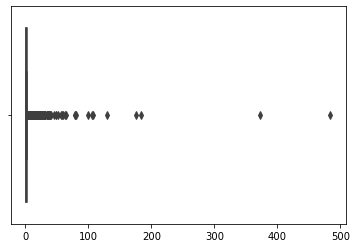

In [14]:
sns.reset_orig() # reset size of figure

x = oct_cohort.counts[:3]
x = x[np.nonzero(x)]
# watch cell value distribution
sns.boxplot(x)
# oct_cohor

In [ ]:
sub_1 = existing_cohort[[1]]
sub_2 = oct_cohort[np.arange(3)]
a_sub_1 = sub_1.convert_to_AnnDataCohort()
a_sub_2 = sub_2.convert_to_AnnDataCohort()
display(a_sub_1.cohort.obs)
display(a_sub_2.cohort.obs)
sub_3 = sub_1 + sub_2
a_sub_3 = sub_3.convert_to_AnnDataCohort()
display(a_sub_3.cohort.obs)

In [ ]:
sns.distplot(sub_1)

In [ ]:
sns.distplot(sub_2)

In [6]:
print(oct_cohort.number_of_cells)
a, b = oct_cohort.get_cancer_immune_stroma_map()
Counter(b)

143429


Counter({'is_cancer': 66446, 'is_immune': 71149, 'is_stroma': 5834})

In [7]:
sum(list(dict(Counter(b)).values()))

143429

In [9]:
annCohort = oct_cohort.convert_to_AnnDataCohort()

In [16]:
annCohort.cohort.obs

,sample,barcode,cell_type_list,conflict_related_cell_types,is_apoptosis,is_immune,is_cancer,cancer_immune_conflict,is_doublet,is_lymphoid,is_myeloid,is_CelBender_empty,is_stromal,is_epithelial,should_be_removed,comment,is_responder
0,M147,AAACCTGAGGAATCGC-1,[],[],False,False,True,False,False,False,False,False,False,False,False,None,False
1,M147,AAACCTGAGGACATTA-1,"[T cells, CD8 Cytotoxic T cells, Immune_general]",[],False,True,False,False,False,True,False,False,False,False,False,None,False
2,M147,AAACCTGAGGCGATAC-1,"[T cells, Exhausted T cells, CD8 Cytotoxic T c...",[],False,True,False,False,False,True,False,False,False,False,False,None,False
3,M147,AAACCTGAGGCTACGA-1,[],[],False,False,True,False,False,False,False,False,False,False,False,None,False
4,M147,AAACCTGCAGCTCGAC-1,"[T cells, Exhausted T cells, CD8 Cytotoxic T c...",[],False,True,False,False,False,True,False,False,False,False,False,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143424,M173,TTTGTCACAAACTGTC-1,[],[],False,False,True,False,False,False,False,False,False,False,False,None,False
143425,M173,TTTGTCACAACGATGG-1,"[Immune_general, Activated T cells, T cells, E...",[],False,True,False,False,False,True,False,False,False,False,False,None,False
143426,M173,TTTGTCAGTCAAACTC-1,"[T cells, CD8 Cytotoxic T cells, Immune_general]",[],False,True,False,False,False,True,False,False,False,False,False,None,False
143427,M173,TTTGTCAGTGCCTGCA-1,"[T cells, Exhausted T cells, CD8 Cytotoxic T c...",[],False,True,False,False,False,True,False,False,False,False,False,None,False


In [2]:
file = r'/storage/md_keren/shitay/outputs/cNMF/conversions/tumor_filtered_cNMF_4.11.21.txt'


In [3]:
with open(file) as f:
    lines = f.readlines()

In [11]:
line_0 = lines[0].split('\t')
line_1 = lines[-1].split('\t')

71.0